<a href="https://colab.research.google.com/github/dineshRaja29/RNNinTensorFlowusingKeras/blob/main/LSTM_AMAZON_FOOD_REVIEWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# from tqdm import tqdm
import os

/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [ ]:
# using SQLite Table to read data.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from PIL import Image

con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
tables =pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'",con); print(tables)
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 
# for tsne assignment you can take 5k data points

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
      name
0  Reviews
Number of data points in our data (100000, 10)


In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
from bs4 import BeautifulSoup
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() )
    preprocessed_reviews.append(sentance.strip())
print("\n",preprocessed_reviews)
labels = final['Score']

100%|██████████| 87773/87773 [00:32<00:00, 2705.66it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Preprocessing of Data 

In [ ]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(preprocessed_reviews)
dictionary = (t.word_index)
top_words = 5000
preprocessed_reviews_oneHotEncoding = []

for review in preprocessed_reviews:
  numberList = []
  for word in review.split():
    if (word in dictionary ):
       number = dictionary[word]
       if number <= top_words:
          numberList.append(number)
  preprocessed_reviews_oneHotEncoding.append(numberList)


print(len(preprocessed_reviews_oneHotEncoding))
print(len(preprocessed_reviews_oneHotEncoding[0]))

87773
64


# LSTM ON AMAZON FOOD REVIEWS MODEL I

In [ ]:
import numpy
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

#### Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(preprocessed_reviews_oneHotEncoding,labels,test_size = 0.3,random_state = 0,shuffle = False)

#### Dynamic Graph 

In [ ]:
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('Binary Crossentropy Loss')
  plt.title('\nBinary Crossentropy Loss VS Epochs')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[99])

(61441, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [ ]:
from keras.layers import Dropout
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.5))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
dropout_3 (Dropout)          (None, 600, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs = 10, batch_size=128, verbose=1,validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 61441 samples, validate on 26332 samples
Epoch 1/10
61441/61441 [==============================] - 1009s 16ms/step - loss: 0.3170 - acc: 0.8721 - val_loss: 0.2436 - val_acc: 0.8973
Epoch 2/10
61441/61441 [==============================] - 1028s 17ms/step - loss: 0.2074 - acc: 0.9192 - val_loss: 0.2825 - val_acc: 0.9045
Epoch 3/10
61441/61441 [==============================] - 1050s 17ms/step - loss: 0.1899 - acc: 0.9274 - val_loss: 0.2773 - val_acc: 0.8839
Epoch 4/10
61441/61441 [==============================] - 1042s 17ms/step - loss: 0.1954 - acc: 0.9250 - val_loss: 0.2209 - val_acc: 0.9171
Epoch 5/10
61441/61441 [==============================] - 1045s 17ms/step - loss: 0.1685 - acc: 0.9369 - val_loss: 0.2153 - val_acc: 0.9198
Epoch 6/10
61441/61441 [==============================] - 1043s 17ms/step - loss: 0.1615 - acc: 0.9390 - val_loss: 0.2090 - val_acc: 0.9173
Epoch 7/10
61441/61441 [==============================] - 1046s 17ms/step - loss: 0.1560 - acc: 0.9401 - val_l

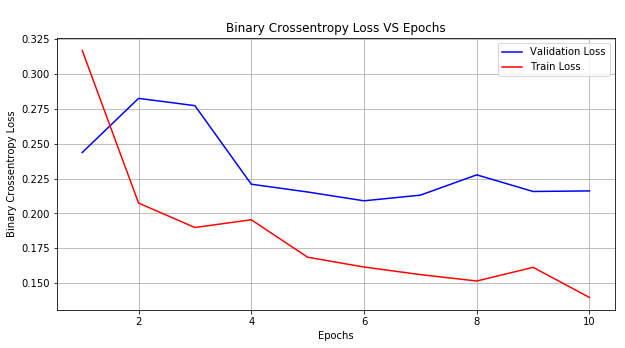

In [ ]:
import matplotlib.pyplot as plt
x = list(range(1,11))
train_acc_1  = history.history['acc']
val_acc_1    = history.history['val_acc']
vy_1 = history.history['val_loss']
ty_1 = history.history['loss']
plt_dynamic(x, vy_1, ty_1)

# LSTM ON AMAZON FOOD REVIEWS MODEL II

In [ ]:
from keras.layers import Dropout
embedding_vecor_length = 32
model_ii = Sequential()

model_ii.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model_ii.add(LSTM(100,return_sequences=True))
model_ii.add(LSTM(100))
model_ii.add(Dropout(0.5))

model_ii.add(Dense(1, activation='sigmoid'))
model_ii.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ii.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_3 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 293,733
Trainable params: 293,733
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model_ii.fit(X_train, y_train, epochs = 6, batch_size=128, verbose=1,validation_data=(X_test, y_test))
scores = model_ii.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 61441 samples, validate on 26332 samples
Epoch 1/6
61441/61441 [==============================] - 2024s 33ms/step - loss: 0.2702 - acc: 0.8955 - val_loss: 0.2251 - val_acc: 0.9103
Epoch 2/6
61441/61441 [==============================] - 2029s 33ms/step - loss: 0.2239 - acc: 0.9096 - val_loss: 0.2253 - val_acc: 0.9142
Epoch 3/6
61441/61441 [==============================] - 2026s 33ms/step - loss: 0.1760 - acc: 0.9317 - val_loss: 0.2080 - val_acc: 0.9162
Epoch 4/6
61441/61441 [==============================] - 2025s 33ms/step - loss: 0.1622 - acc: 0.9383 - val_loss: 0.2103 - val_acc: 0.9178
Epoch 5/6
61441/61441 [==============================] - 2020s 33ms/step - loss: 0.1502 - acc: 0.9431 - val_loss: 0.2283 - val_acc: 0.9182
Epoch 6/6
61441/61441 [==============================] - 2021s 33ms/step - loss: 0.1445 - acc: 0.9455 - val_loss: 0.2277 - val_acc: 0.9180
Accuracy: 91.80%


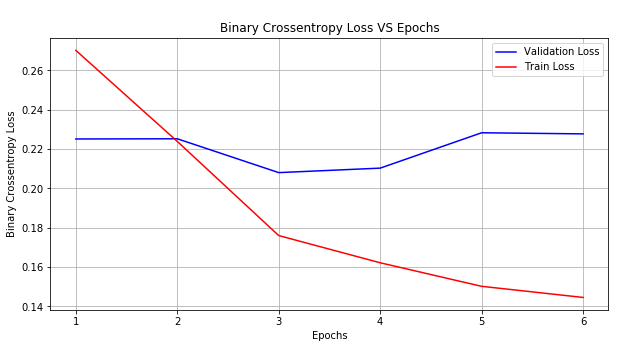

In [ ]:
import matplotlib.pyplot as plt
x = list(range(1,7))
train_acc_1  = history.history['acc']
val_acc_1    = history.history['val_acc']
vy_1 = history.history['val_loss']
ty_1 = history.history['loss']
plt_dynamic(x, vy_1, ty_1)

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("S.NO",[1,2])
x.add_column("#f Epochs",[6,6])
x.add_column("Model Description",["Model with 1 layer of LSTM + Dropout","Model with 2 layer of LSTM + Dropout"])
x.add_column("Train Accuracy",["0.9390","0.9455"])
x.add_column("Validation Accuracy",["0.9173" ,"0.9180" ])
print(x)

+------+-----------+--------------------------------------+----------------+---------------------+
| S.NO | #f Epochs |          Model Description           | Train Accuracy | Validation Accuracy |
+------+-----------+--------------------------------------+----------------+---------------------+
|  1   |     6     | Model with 1 layer of LSTM + Dropout |     0.9390     |        0.9173       |
|  2   |     6     | Model with 2 layer of LSTM + Dropout |     0.9455     |        0.9180       |
+------+-----------+--------------------------------------+----------------+---------------------+
